# Initial Model for Brain Tumour Segmentation using MONAI

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

In [2]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from matplotlib.axes import Axes
from monai.losses import DiceLoss
from monai.networks.nets import SegResNet, UNETR
from torch import Tensor
from tqdm import tqdm

from dataloader import BrainTumourDataModule

import wandb

/home/tmb2k01/deep_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tmb2k01 (tmb2k01-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin


True

## Wrapping SegResNet

The input data must have a shape of (B, N, H, W, D) format

- B - batch size
- N - number of classes
- H - height
- W - width
- D - depth


In [4]:
class SegResModel(pl.LightningModule):
    def __init__(self, in_channels, out_channels, learning_rate=1e-3):
        super(SegResModel, self).__init__()
        self.model = SegResNet(in_channels=in_channels, out_channels=out_channels)
        self.dice_loss = DiceLoss(softmax=True)
        self.learning_rate = learning_rate

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        loss, _ = self._common_step(batch, batch_idx)

        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self._common_step(batch, batch_idx)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def _common_step(
        self, batch: Tuple[Tensor, Tensor], batch_idx: int
    ) -> Tuple[Tensor, Tensor]:
        images, labels = batch
        preds = self.forward(images)
        loss = self.dice_loss(preds, labels)
        return loss, preds

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [5]:
class UNetModel(pl.LightningModule):
    def __init__(self, in_channels, out_channels, learning_rate=1e-3):
        super(UNetModel, self).__init__()
        self.model = UNETR(
            in_channels=4,
            out_channels=4,
            img_size=(128, 128, 128),
        )
        self.dice_loss = DiceLoss(softmax=True)
        self.learning_rate = learning_rate

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        loss, _ = self._common_step(batch, batch_idx)
        return loss

    def _common_step(
        self, batch: Tuple[Tensor, Tensor], batch_idx: int
    ) -> Tuple[Tensor, Tensor]:
        images, labels = batch
        preds = self.forward(images)
        loss = self.dice_loss(preds, labels)
        return loss, preds

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [6]:
class EnsembleModel(pl.LightningModule):
    def __init__(self, model_list, num_classes):
        super(EnsembleModel, self).__init__()
        self.models: List[pl.LightningModule] = model_list
        self.num_classes: int = num_classes

    def forward(self, x):
        for model in self.models:
            model.eval()

        predictions = [model(x) for model in self.models]
        averaged_prediction = torch.mean(torch.stack(predictions), dim=0)
        return averaged_prediction

## Data Module Loading


In [7]:
image_path = "../data/BrainTumourData/imagesTr/"
label_path = "../data/BrainTumourData/labelsTr/"
img_dim = (128, 128)
batch_size = 1

data_module = BrainTumourDataModule(
    data_path=image_path, seg_path=label_path, img_dim=img_dim, batch_size=batch_size
)
data_module.prepare_data()
data_module.setup()

## Training the Model


In [8]:
# Instantiate each model
segresnet = SegResModel(in_channels=4, out_channels=4)

# Train each model separately
wandb_logger = pl.loggers.WandbLogger(
    project="medical-image-segmentation", log_model="all"
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")
trainer = pl.Trainer(
    max_epochs=20,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(segresnet, data_module)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | SegResNet | 1.2 M  | train
1 | dice_loss | DiceLoss  | 0      | train
------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.707     Total estimated model params size (MB)
137       Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 328/328 [02:17<00:00,  2.38it/s, v_num=2z5s, val_loss=0.255]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 328/328 [02:17<00:00,  2.38it/s, v_num=2z5s, val_loss=0.255]


epoch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
train_loss_epoch,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss_step,██▅▇▄▃▃▄▂▂▃▂▄▁▂▂▃▂▃▂▄▃▄▃▄▃▃▄▃▃▃▃▂▄▄▃▃▃▁▄
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
val_loss,█▄▄▃▃▃▂▂▁▂▂▂▁▂▁▂▁▁▁▁
epoch,19
train_loss_epoch,0.26021
train_loss_step,0.38634
trainer/global_step,6559
val_loss,0.25536


In [9]:
# Instantiate each model
unet = UNetModel(in_channels=4, out_channels=4)

# Train each model separately
wandb_logger = pl.loggers.WandbLogger(
    project="medical-image-segmentation", log_model="all"
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")
trainer = pl.Trainer(
    max_epochs=10,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(unet, data_module)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/tmb2k01/deep_learning/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params | Mode 
-----------------------------------------------
0 | model     | UNETR    | 130 M  | train
1 | dice_loss | DiceLoss | 0      | train
-----------------------------------------------
130 M     Trainable params
0         Non-trainable params
130 M     Total params
523.156   Total estimated model params size (MB)
448       Modules in train mode
0         Modules in eval mode


Epoch 1:   0%|          | 0/328 [00:00<?, ?it/s, v_num=b4ej]          

/home/tmb2k01/deep_learning/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Epoch 9: 100%|██████████| 328/328 [02:02<00:00,  2.68it/s, v_num=b4ej]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 328/328 [02:02<00:00,  2.68it/s, v_num=b4ej]


In [10]:
ensemble_model = EnsembleModel([segresnet, unet], num_classes=4)

## Running Tests


In [11]:
image_list: List[Tensor] = []
prediction_list: List[Tensor] = []
label_list: List[Tensor] = []

for images, label in tqdm(data_module.test_dataloader()):
    with torch.no_grad():
        pred: Tensor = ensemble_model(images)
        image_list.append(images)
        prediction_list.append(pred)
        label_list.append(label)

images: Tensor = torch.cat(image_list, dim=0)
predictions: Tensor = torch.cat(prediction_list, dim=0)
labels: Tensor = torch.cat(label_list, dim=0)

print(f"images shape: {images.shape}")
print(f"predictions shape: {predictions.shape}")
print(f"labels shape: {labels.shape}")

100%|██████████| 59/59 [02:22<00:00,  2.41s/it]


images shape: torch.Size([59, 4, 128, 128, 128])
predictions shape: torch.Size([59, 4, 128, 128, 128])
labels shape: torch.Size([59, 4, 128, 128, 128])


## Prediction Visualization


In [12]:
def plot_slices(image: Tensor, label: Tensor, pred: Tensor, slice_index: int) -> None:
    image_slice: np.ndarray = image[0, :, :, slice_index].cpu().numpy()
    labels_map: Tensor = torch.argmax(label, dim=0)
    preds_map: Tensor = torch.argmax(pred, dim=0)

    labels_slice: np.ndarray = labels_map[:, :, slice_index].cpu().numpy()
    preds_slice: np.ndarray = preds_map[:, :, slice_index].cpu().numpy()

    axes: Tuple[Axes, Axes, Axes]
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes_orig: Axes = axes[0]
    axes_truth: Axes = axes[1]
    axes_pred: Axes = axes[2]

    axes_orig.imshow(image_slice, cmap="gray")
    axes_orig.set_title("Original MRI Image")
    axes_orig.axis("off")

    axes_truth.imshow(labels_slice, cmap="jet")
    axes_truth.set_title("Ground Truth")
    axes_truth.axis("off")

    axes_pred.imshow(preds_slice, cmap="jet")
    axes_pred.set_title("Predictions")
    axes_pred.axis("off")

    plt.show()

In [13]:
idx = 0

image = images[idx]
print(f"image shape: {image.shape}")

label = labels[idx]
print(f"labels shape: {label.shape}")

pred = predictions[idx]
print(f"preds shape: {pred.shape}")

image shape: torch.Size([4, 128, 128, 128])
labels shape: torch.Size([4, 128, 128, 128])
preds shape: torch.Size([4, 128, 128, 128])


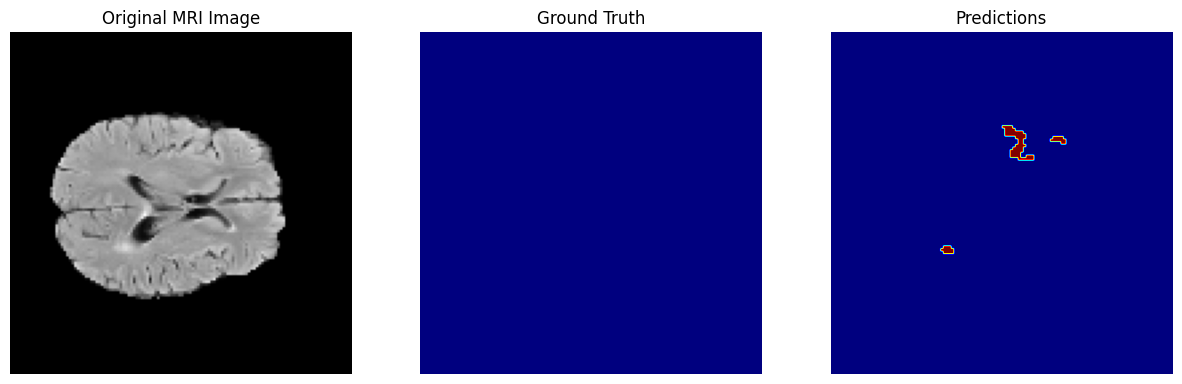

In [14]:
plot_slices(image, label, pred, slice_index=image.shape[3] // 2)